In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# import the dataset
df = pd.read_csv(r'/kaggle/input/house-prediction-project1/data.csv')
df.head()
df.shape
df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [3]:
# remove unnecessary columns
columns_to_remove = ['date',
     'waterfront', 'condition', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country']

original_df = df.drop(columns = columns_to_remove)

In [4]:
original_df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'sqft_above'],
      dtype='object')

In [5]:
original_df.shape

(4600, 8)

In [6]:
# remove using IQR method
n = original_df.shape[0]
Q1 = original_df.quantile(0.25)
Q3 = original_df.quantile(0.75)


# Calculate the IQR (Interquartile Range) for each column
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows that contain outliers
# Since you applied ~, it selects only the rows where none of the values are outliers (i.e., the rows 
# that don’t contain any values greater than the upper bound or less than the lower bound).
df_cleaned = original_df[~((original_df < lower_bound) | (original_df > upper_bound)).any(axis=1)]

print("Size before removing outliers:", original_df.shape)
print("Size after removing outliers:", df_cleaned.shape)


Size before removing outliers: (4600, 8)
Size after removing outliers: (3463, 8)


In [7]:
x = np.array(df_cleaned.drop(columns = ['price']))
y = np.array(df_cleaned['price'])

x_mean = np.mean(x)
std_x = np.std(x)

# Check if std_x is not equal to zero before dividing
if std_x != 0:
    x_norm = (x - x_mean) / std_x
else:
    print("Standard deviation is zero, skipping normalization.")
    x_norm = x 

y_mean = y.mean(axis=0)
std_y = y.std(axis=0)
y_norm = (y - y_mean) / std_y

In [8]:
# formula = 1 / 2m ∑ (predicted - actual) ** 2

def compute_cost(w, x, y, b, lamda):
    m = len(x)
    total_cost = 0
    for i in range(m):
        prediction = np.dot(w, x[i]) + b
        total_cost += (prediction - y[i]) ** 2
    total_cost = total_cost / (2 * m)
    
    # should be scalar output
    reg = 0
    n = len(w)
    for j in range(n):
        reg += w[j] ** 2

    reg = lamda / (2 * m) * reg

    return total_cost + reg

In [9]:
# formula 
# w = w  - alpha (dj / dw) * x
# b = b - alpha (db / db)

def compute_gradient(w, x, y, b):

    m = len(x)
    dw = np.zeros_like(w)
    db = 0

    for i in range(m):
        prediction = np.dot(w, x[i]) + b
        dw += (prediction -  y[i]) * x[i]
        db += (prediction -  y[i])

        
    dw /= m
    db /= m

    return dw, db

In [10]:
# formula
# w = w  - alpha (dj / dw) * x
# b = b - alpha (dj / db)

import math
def gradient_descent(alpha, w, x, b, y,iterations):
    
    J = []
    # cost function output should be scalar
    prev_cost=compute_cost(w,x,y,b, 0.7)
    print("prev", prev_cost)
    for i in range(iterations):

        dw, db = compute_gradient(w, x, y, b)

        w = w - alpha * dw
        b = b - alpha * db
        curr_cost=compute_cost(w,x,y,b, 0.7)
        if i % 100 == 0 :
            J.append(curr_cost)
            print(f"Iteration {i:4}: Cost {(J[-1]):8.6f}   ")
        if(abs(prev_cost-curr_cost)<1e-7):
            break
        prev_cost=curr_cost
    return w,b, J

initial_w = np.random.randn(7)
initial_b = 0.25
alpha = 0.001
w,b,cost = gradient_descent(alpha, initial_w, x_norm, initial_b, y_norm, 
                     1000)

# we have 6 features, so 6 weights and bias
print("w found by gradient descent:", w)
print("b found : ", b)


prev 13.914838138263722
Iteration    0: Cost 13.723396   
Iteration  100: Cost 3.825947   
Iteration  200: Cost 1.575727   
Iteration  300: Cost 1.054057   
Iteration  400: Cost 0.923634   
Iteration  500: Cost 0.882257   
Iteration  600: Cost 0.861597   
Iteration  700: Cost 0.846172   
Iteration  800: Cost 0.832441   
Iteration  900: Cost 0.819566   
w found by gradient descent: [-0.67613607  0.84762473 -1.49138074 -0.163176    0.28699554 -0.28716409
 -0.02558859]
b found :  0.7257625609368489


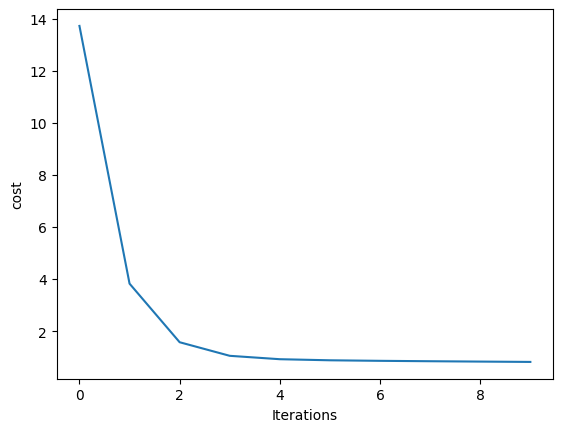

In [11]:
plt.plot(cost)
plt.xlabel('Iterations')
plt.ylabel('cost')
plt.show()

In [12]:
feature_names = original_df.drop(columns=['price']).columns
print(feature_names)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'sqft_above'],
      dtype='object')


In [13]:
# New data (before normalization)
new_data = np.array([4, 2, 1820, 5000, 2, 1, 1640])

# Normalize the new data using the same max values as the training data
new_norm = (new_data - x_mean) / std_x  # Use max values from training data for consistency

print("Normalized new data:", new_norm)

# Now make the prediction using the normalized new data
predicted_price = np.dot(w, new_norm) + b
print(f"Predicted price: {predicted_price * y_mean + std_y}")


Normalized new data: [-0.54365013 -0.54435998  0.10088911  1.22954262 -0.54435998 -0.5447149
  0.03700306]
Predicted price: 326666.04294012045


In [14]:
# Regularization method
# formula  = lambda / 2m ∑ (wj **2)

def compute_cost(w, x, y, b, lamda):
    m = len(x)
    # formula = 1 / 2m ∑ (predicted - actual) ** 2
    total_cost = 0
    for i in range(m):
        prediction = np.dot(w, x[i]) + b
        total_cost += (prediction - y[i]) ** 2
    total_cost = total_cost / (2 * m)
    
    # should be scalar output
    reg = 0
    for j in range(m):
        reg += w[j] ** 2

    reg = lamda / (2 * m) * reg

    return totalcost + reg